In [1]:
import vcsn

In [2]:
from IPython.display import display
import ipywidgets as widgets
import traitlets

class Automaton(widgets.DOMWidget):
    # the name of the Backbone.View subclass to be used
    _view_name = traitlets.Unicode('AutomatonView').tag(sync=True)
    _view_module = traitlets.Unicode('AutomatonD3Widget').tag(sync=True)
    states = traitlets.List().tag(sync=True)
    transitions = traitlets.List().tag(sync=True)
    lastStateId = traitlets.CInt().tag(sync=True)

In [3]:
%%javascript
require.config({paths: {d3: "http://d3js.org/d3.v3.min"}});

<IPython.core.display.Javascript object>

In [4]:
%%javascript
require.undef('AutomatonD3Widget');

define('AutomatonD3Widget',
       ['jupyter-js-widgets', 'd3'],
       function(widgets, d3) {
    var AutomatonView = widgets.DOMWidgetView.extend({

        // RENDER THE VIEW
        render: function(){
            // Here we define variables with 'this' to call them from everywhere

            // Editable text for labels
            this.svg_for_frame = d3.select(this.el).append('svg')
                .attr('width', 960)
                .attr('height', 100)
            this.frame_title = this.svg_for_frame.append('svg:text')
                .text('Label: ')
                .attr('x', 25)
                .attr('y', 25)
            this.frame = this.svg_for_frame.append('foreignObject')
                .attr('x', 85)
                .attr('y', 10)
                .attr("width", 800)
                .attr("height", 50)
                .append("xhtml:form")
                .attr('class', 'frame')
                .append('input')

            // Attributs of the SVG
            this.width =960, this.height = 500;

            // Render the svg
            this.svg = d3.select(this.el).append('svg')
                .attr('width', this.width)
                .attr('height', this.height)
                .style('userSelect' , "none")
                .style('webkiUserSelect' , "none")
                .style('MozUserSelect' , "none")
                .style('oUserSelect', 'none')
                .style('msUserSelect', 'none')
                .style('draggable', 'false')
                .classed('m', false)
                .style('cursor', 'crosshair')

            // Initialize datas
            this.states = this.model.get('states');
            var trans = this.model.get('transitions');
            this.transitions = this.completeTransitions(trans);
            this.lastStateId = this.states[this.states.length - 1].id;

            // Define here to avoid recreation in every update
            this.path = this.svg.append('svg:g').selectAll('g');
            this.circle = this.svg.append('svg:g').selectAll('g');

            // Lines displayed when draggind new states
            this.drag_line = this.svg.append('svg:path')
                .style('fill', 'none')
                .style('stroke', '#000')
                .style('stroke-width', '1.50px')
                .attr('class', 'transition dragline hidden')
                .attr('d', 'M0,0L0,0');

            // Arrow for transitions
            this.svg.append('svg:defs').append('svg:marker')
                .attr('id', 'end-arrow')
                .attr('viewBox', '-3 -10 20 20')
                .attr('refX', 2)
                .attr('markerWidth', 6)
                .attr('markerHeight', 6)
                .attr('orient', 'auto')
              .append('svg:path')
                .attr('d', 'M-3,12 l22,-12 l-22,-12 l7,12 Z')
                .attr('fill', '#000');

            // Closure
            var that = this;

            // Catch source and target with their ID
            for(var c = 0; c <= this.transitions.length -1; c++)
                {
                    this.transitions[c].source = this.idToState(this.transitions[c].source);
                    this.transitions[c].target = this.idToState(this.transitions[c].target);
                }

            // Force layout for physical simulation
            this.force = d3.layout.force()
                .nodes(this.states)
                .links(this.transitions)
                .size([this.width, this.height])
                .linkDistance(function(d) {
                    if(that.isShort(d)) {return 75;}
                    else { return 175;}
                })
                .charge(function(d) {
                    if(that.isHidden(d)) {return -100;}
                    else {return -750;}
                })
                .on('tick', function(d,i){ that.stepForce(this, d, i);})

            // Listen for mouse and keyboard events on the whole document
            this.svg.on('mousedown', function(d,i){ that.mousedown(this, d, i);})
                .on('mousemove', function(d,i){ that.mousemove(this, d, i);})
                .on('mouseup', function(d,i){ that.mouseup(this, d, i);})
            // Active keyboard action and disable notebook shortcuts when we are
            // over the widget
                .on("mouseover", function(d,i) {
                    // Disable some notebook key shortcuts
                    var cmd = IPython.keyboard_manager.command_shortcuts;
                    cmd.remove_shortcut('i');
                    cmd.remove_shortcut('l');
                    cmd.remove_shortcut('f');
                    cmd.remove_shortcut('m');
                    cmd.remove_shortcut('s');

                    d3.select(window).on('keydown', function(d,i){
                        that.keydown(this, d, i);})
                        .on('keyup',  function(d,i){
                            that.keyup(this, d, i);});
                })
            // if we leave the widget area, then disable keyboard action and
            // reactive notebook shortcuts
                .on("mouseout", function(d,i) {
                    // reset selections if we leave widget
                    // that.selected_transition = null;
                    // that.selected_state = null;
                    // that.mousedown_state = null;
                    // that.mouseup_state = null;
                    // that.mousedown_transition = null;
                    var cmd = IPython.keyboard_manager.command_shortcuts;
                        cmd.add_shortcut('i', {
                            help    : 'interrupt kernel (press twice)',
                            help_index : 'ha',
                            count: 2,
                            handler : function (event) {
                                IPython.notebook.kernel.interrupt();
                                return false;
                            }
                        });
                        cmd.add_shortcut('l', {
                            help    : 'toggle line numbers',
                            help_index : 'ga',
                            handler : function (event) {
                                IPython.notebook.cell_toggle_line_numbers();
                                return false;
                            }
                        });
                        cmd.add_shortcut('m', {
                            help    : 'to markdown',
                            help_index : 'cb',
                            handler : function (event) {
                                IPython.notebook.to_markdown();
                                return false;
                            }
                        });
                        cmd.add_shortcut('s', {
                            help    : 'save notebook',
                            help_index : 'fa',
                            handler : function (event) {
                                IPython.notebook.save_checkpoint();
                                return false;
                            }
                        });
                    d3.select(window).on('keydown', function() {
                        return null})
                        .on('keyup', function() {return null;});
                });

            this.hackUpdate();
        },

        hackUpdate: function(){
            // Little hack to update model without touch the view
            // Launched at the begginning avoid conversion error
            // Between VCSN and D3

            var old_transitions = this.transitions
            var transition = {'source': '0', 'target':'0', 'label': ''}
            var new_transitions = this.model.get('transitions').slice();
            new_transitions.push(transition);
            this.model.set('transitions', new_transitions);
            this.touch();

            this.model.set('transitions', old_transitions);
            this.touch();

            this.update();
        },

        // SET POSITIONS OF EVERY ELEMENTS
        stepForce: function(doc, da, i) {

            var that = this;
            // Draw transitions with proper padding from state centers
            this.path.selectAll('path').attr('d', function(d) {

                var deltaX = d.target.x - d.source.x ,
                deltaY = d.target.y - d.source.y,
                dist = Math.sqrt(deltaX * deltaX + deltaY * deltaY),
                normX = deltaX / dist,
                normY = deltaY / dist,
                sourcePadding = 20,
                targetPadding = 29,
                sourceX = d.source.x + (sourcePadding * normX),
                sourceY = d.source.y + (sourcePadding * normY),
                targetX = d.target.x - (targetPadding * normX),
                targetY = d.target.y - (targetPadding * normY),
                source_doubleX = d.source.x + (20 * normX),
                source_doubleY = d.source.y + (20 * normY),
                target_doubleX = d.target.x + (50 * normX),
                target_doubleY = d.target.y + (50 * normY);

                // Commons transitions
                if((d.target != d.source) &&
                   !(that.existingTrans(d,that.transitions))) {

                    return 'M' + sourceX + ',' + sourceY +
                        'L' + targetX + ',' + targetY;
                }
                // Curve for double transitions
                else if((d.target != d.source) &&
                        that.existingTrans(d,that.transitions)) {

                    return "M" + (sourceX - (normY*10))  +',' + (sourceY + (normX*10)) +
                        "q" + ((-normY*20 + (targetX-sourceX)/2)) + ',' +
                        ((normX*20 + (targetY-sourceY)/2)) + " " +
                        (targetX - sourceX) + ',' + (targetY - sourceY);
                }
                // Curve for the loop
                else {
                    return "M" + (d.source.x-5)  +',' +
                        (d.source.y-17) + " c -50,-50 50,-50 18,-9  ";
                }
            });

            // Set States positions
            this.circle.attr('transform', function(d) {
                return 'translate(' + d.x + ',' + d.y + ')';
            });

            // Draw label horizontally on transitions with proper position
            this.svg.selectAll("text.transitionlabelholder")
                 .attr('transform', function(d) {
                     // On commons transitions
                     if((d.target != d.source)
                        && !(that.existingTrans(d,that.transitions))) {

                         return 'translate(' +
                             (d.target.x - (d.target.x - d.source.x)/2) + ',' +
                             ((d.target.y - (d.target.y - d.source.y)/2)-8) + ')';
                     }
                     // On doubles transitions
                     else if((d.target != d.source) &&
                             that.existingTrans(d,that.transitions)){
                         var deltaX = d.target.x - d.source.x ,
                         deltaY = d.target.y - d.source.y,
                         dist = Math.sqrt(deltaX * deltaX + deltaY * deltaY),
                         normX = deltaX / dist,
                         normY = deltaY / dist,
                         sourcePadding = 20,
                         targetPadding = 29,
                         sourceX = d.source.x + (sourcePadding * normX),
                         sourceY = d.source.y + (sourcePadding * normY),
                         targetX = d.target.x - (targetPadding * normX),
                         targetY = d.target.y - (targetPadding * normY);

                         return 'translate(' +
                             (sourceX + (-normY*20 + (targetX-sourceX)/2)) + ',' +
                             (sourceY + (normX*20 + (targetY-sourceY)/2)) + ')';
                     }
                     // On loops
                     else {
                         return 'translate(' + (d.source.x -5) + ',' +
                             (d.target.y - 60) + ')';
                     }
                 });
         },

        // MOUSE FUNCTIONS
        resetMouseVars: function(){
            this.mousedown_state = null;
            this.mouseup_state = null;
            this.mouseover_state = null;
            this.mousedown_transition = null;
        },
        mousedown: function(doc, data, id){
            d3.event.preventDefault();

            // Active for webkit
            this.svg.classed('active', true);

            if(d3.event.ctrlKey || this.mousedown_state || this.mousedown_transition) return;
            if(!(this.svg.classed('m'))) {
                // insert new state at point
                var point = d3.mouse(doc);
                var lastState = this.lastStateValidId(this.states);
                var state = {id: lastState + 1};
                state.x = point[0];
                state.y = point[1];
                var new_states = this.model.get('states').slice();
                new_states.push(state);
                this.model.set('states', new_states);
                this.touch();
                this.states = new_states;
                this.model.set("lastStateId", this.lastStateId);
                this.touch();
            }
            this.update();
        },
        mousemove: function(doc, data, id){
            if(!this.mousedown_state) return;
            // update drag line
            if(this.svg.classed('m') == false)
                this.drag_line.attr('d', 'M' + this.mousedown_state.x + ',' +
                                    this.mousedown_state.y + 'L' +
                                    d3.mouse(doc)[0] + ',' + d3.mouse(doc)[1]);
            this.update();
        },
        mouseup: function(doc, data, id){

            // add new transition when we are dragging from a state
            if(this.mousedown_state && this.mouseover_state) {
                this.drag_line.classed('hidden', true)
                    .style('marker-end','');
                this.mouseup_state = this.mouseover_state;
                if(this.mouseup_state === this.mousedown_state) {
                    this.resetMouseVars(); return;
                }

                // add transition and update if already exist
                var source, target;
                    source = this.mousedown_state;
                    target = this.mouseup_state;
                var transition;
                transition = this.transitions.filter(function(l) {
                    return (l.source === source && l.target === target);
                })[0];

                // a transparent state can't have other transitions
                if(!this.isHidden(this.mousedown_state) &&
                  !this.isHidden(this.mouseup_state))
                {
                    if(!transition) {
                        transition = {source: source, target: target, label: 'b'};
                        var new_transitions = this.model.get('transitions').slice();
                        new_transitions.push(transition);
                        this.model.set('transitions', new_transitions)
                        this.touch();
                    }
                }

                // Reset variable and select the new transition
                this.selected_transition = transition;
                this.selected_state = null;
                this.mousedown_state = null;
                this.mouseup_state = null;
                this.mousedown_transition = null;
                this.update();
            }

            // because :active only works in WebKit
            this.svg.classed('active', false);
            this.drag_line.classed('hidden', true);

            // clear mouse event vars
            this.resetMouseVars();
        },

        // KEYBOARD FUNCTIONS
        spliceTransitionsForState: function(state, transitions){
            var toSplice = transitions.filter(function(l) {
                return (l.source === state || l.target === state);
            });
            toSplice.map(function(l) {
                transitions.splice(transitions.indexOf(l), 1);
            });
        },

        keydown: function(doc, d , i){

            if(this.lastKeyDown !== -1) return;
            this.lastKeyDown = d3.event.keyCode;

            // m
            if(d3.event.keyCode === 77) {
                this.circle.call(this.force.drag);
                this.svg.classed('m', true);
            }

            if(!this.selected_state && !this.selected_transition && !this.selected_frame) return;
            switch(d3.event.keyCode) {
                case 8:
                case 66: // key delete
                    if(!this.overtext){
                        if(this.selected_state) {
                            var new_transitions = this.model.get('transitions').slice();
                            this.states.splice(this.states.indexOf(this.selected_state), 1);
                            this.spliceTransitionsForState(this.selected_state, new_transitions);
                            this.model.set('transitions', new_transitions)
                            this.touch();
                        }
                        else if(this.selected_transition && !this.overtext) {
                            if(this.selected_transition.target == this.selected_transition.source){
                                var new_transitions = this.model.get('transitions').slice();
                                new_transitions.splice(new_transitions.indexOf(this.selected_transition), 1);
                                this.model.set('transitions', new_transitions)
                                this.touch();
                            }
                            else {
                                var new_transitions = this.model.get('transitions').slice();
                                new_transitions.splice(new_transitions.indexOf(this.selected_transition), 1);
                                this.model.set('transitions', new_transitions)
                                this.touch();

                            }
                        }
                        if(!this.overtext) {
                            this.selected_transition = null;
                            this.selected_state = null;
                        }
                        this.update();
                        break;
                    }
                case 83: // key S : fix a node
                    if(!this.overtext){
                        if(this.selected_state) {
                            this.selected_state.fixed = true;
                        }
                    }
                    this.update();
                    break;
                case 70: // key F : create final transition
                    if(!(this.isHidden(this.selected_state)) && !this.overtext){
                        if(this.selected_state) {
                            if(!(this.isFinal(this.selected_state, this.transitions))) {
                                var pointx = this.selected_state.x,
                                    pointy = this.selected_state.y,
                                    state = {id: (this.selected_state.id) + 0.2};
                                state.x = pointx +75;
                                state.y = pointy;
                                var new_states = this.model.get('states').slice();
                                new_states.push(state);
                                this.model.set('states', new_states);
                                this.touch();
                                var transition = {source: this.selected_state, target: state, label: ' '};
                                var new_transitions = this.model.get('transitions').slice();
                                new_transitions.push(transition);
                                this.model.set('transitions', new_transitions);
                                this.touch();
                            }
                            else { // delete final transitions
                                var new_transitions = this.model.get('transitions').slice();
                                this.spliceTransitionsForState(this.findFinalState(this.selected_state, this.states), new_transitions);
                                this.states.splice(this.states.indexOf(this.findFinalState(this.selected_state, this.states)), 1);
                                this.model.set('transitions', new_transitions);
                                this.touch();
                            }
                        }
                    this.update();
                    break;
                    }
                case 73: // key I : create initial transition
                    if(!(this.isHidden(this.selected_state)) && !this.overtext){
                        if(this.selected_state) {
                            if(!(this.isInitial(this.selected_state, this.transitions))) {
                                var pointx = this.selected_state.x,
                                    pointy = this.selected_state.y,
                                    state = {id: (this.selected_state.id) + 0.1};
                                state.x = pointx -75;
                                state.y = pointy;
                                var new_states = this.model.get('states').slice();
                                new_states.push(state);
                                this.model.set('states', new_states);
                                this.touch();
                                var transition = {source: state, target: this.selected_state, label: ' '};
                                var new_transitions = this.model.get('transitions').slice();
                                new_transitions.push(transition);
                                this.model.set('transitions', new_transitions);
                                this.touch();
                            }
                            else { // delete initial transitions
                                var new_transitions = this.model.get('transitions').slice();
                                this.spliceTransitionsForState(this.findInitialState(this.selected_state, this.states), new_transitions);
                                this.states.splice(this.states.indexOf(this.findInitialState(this.selected_state, this.states)), 1);
                                this.model.set('transitions', new_transitions);
                                this.touch();
                            }
                        }
                    this.update();
                    break;
                    }
                case 76: // key L : create loop on node
                    if(!(this.isHidden(this.selected_state)) && !this.overtext){
                        if(this.selected_state && !(this.isLoop(this.selected_state, this.transitions))) {
                            var loop = {source: this.selected_state, target: this.selected_state, label:'a', short: false};
                            var new_transitions = this.model.get('transitions').slice();
                            new_transitions.push(loop);
                            this.model.set('transitions', new_transitions);
                            this.touch();
                        }
                    this.update();
                    break;
                    }
            }
        },

        keyup: function(doc, d, i){
              this.lastKeyDown = -1;
              // m
              if(d3.event.keyCode === 77) {
                this.circle
                  .on('mousedown.drag', null)
                  .on('touchstart.drag', null);
                this.svg.classed('m', false);
              }
        },

        // METHODS
        idToState: function(id){
            for(var j=0; j <= this.states.length -1; j++)
                {
                    if(this.states[j].id == id)
                        {
                            return this.states[j];
                        }
                }
        },
        existingTrans: function(transition, transitions){
            for(var i=0; i<= transitions.length -1; i++){
                if((transitions[i].source == transition.target) &&
                  (transitions[i].target == transition.source)){
                    return true;
                    }
                }
            return false;
        },
        lastStateValidId: function(states){
            for(var t = states.length -1; t>=0; t--)
                    {
                        if((parseFloat((states[t].id)) == parseInt((states[t].id)))
                           && !isNaN((states[t].id)))
                            {
                                return states[t].id;
                            }
                    }

        },
        findFinalState: function(state, states){
            for(var i = 0; i <= states.length -1; i++)
                {
                    if(states[i].id.toString() == (state.id.toString() + '.2'))
                        {
                            return states[i];
                        }
                }
        },
        findInitialState: function(state, states){
            for(var i = 0; i <= states.length -1; i++)
                {
                    if(states[i].id.toString() == (state.id.toString() + '.1'))
                        {
                            return states[i];
                        }
                }
        },
        isInitial: function(state, transitions){
                for(var i=0; i<= transitions.length -1; i++)
                    {
                        if(transitions[i].source.id == state.id ||
                           transitions[i].target.id == state.id)
                            {
                                if(!((parseFloat((transitions[i].source.id)) ==
                                      parseInt((transitions[i].source.id))) &&
                                     !isNaN((transitions[i].source.id))) )
                                    {
                                        return true;
                                    }
                            }
                    }
                return false;
        },
        isFinal: function(state, transitions){
                for(var i=0; i<= transitions.length -1; i++)
                    {
                        if(transitions[i].source.id == state.id ||
                           transitions[i].target.id == state.id)
                            {
                                if(!((parseFloat((transitions[i].target.id)) ==
                                      parseInt((transitions[i].target.id))) &&
                                     !isNaN((transitions[i].target.id))) )
                                    {
                                        return true;
                                    }
                            }
                    }
                return false;
        },
        isHidden: function(state){
                if(!(parseFloat(state.id) == parseInt(state.id) && !isNaN(state.id)))
                    {
                        return true;
                    }
                else{ return false;}
        },
        isShort: function(transition){
                if(!((parseFloat((transition.target.id)) ==
                      parseInt((transition.target.id))) &&
                     !isNaN((transition.target.id)))
                  || !((parseFloat((transition.source.id)) ==
                        parseInt((transition.source.id))) &&
                       !isNaN((transition.source.id))))
                    {
                        return true;
                    }
                else {return false;}

        },
        isLoop: function(state, transitions){
                for(var i =0; i <= transitions.length -1; i++)
                    {
                        if(transitions[i].target.id == transitions[i].source.id)
                            {
                                if(transitions[i].target.id == state.id)
                                    {
                                        return true;
                                    }
                            }
                    }
                return false;
        },
        idToNode: function(id){
            for(var j=0; j <= this.states.length -1; j++)
                {
                    if(this.states[j].id == id)
                        {
                            return this.states[j];
                        }
                }
        },
        completeTransitions: function(transitions){
                for(var i =0; i <= transitions.length -1; i++)
                    {
                        if(transitions[i].length != 3)
                            {
                                if(typeof(transitions[i].source) === 'undefined')
                                    {
                                        //(transitions[i].target)+'.1'
                                        var state = {id:((transitions[i].target)+'.1') };

                                        this.states.push(state);
                                        var trans = {source: state.id.toString()
                                                     , target:transitions[i].target,
                                                     label:transitions[i].label};
                                        transitions.splice(i,1);
                                        transitions.push(trans);
                                        i --;
                                        this.model.set('transitions', transitions);
                                        this.touch();
                                        this.model.set('states', this.states);
                                        this.touch();
                                    }
                                else if(typeof(transitions[i].target) === 'undefined')
                                    {
                                        //(transitions[i].source)+'.2'
                                        var state = {id:((transitions[i].source)+'.2')};
                                        this.states.push(state);
                                        var trans = {source: transitions[i].source,
                                                     target: state.id.toString(),
                                                     label:transitions[i].label}
                                        transitions.splice(i,1);
                                        transitions.push(trans);
                                        i --;
                                        this.model.set('transitions', transitions);
                                        this.touch();
                                        this.model.set('states', this.states);
                                        this.touch();
                                    }
                            }
                    }
            return transitions;
        },

        // UPDATE THE VIEW
        update: function(){

            var colors = d3.scale.category10();
            // Update force
            this.force.nodes(this.states)
                .links(this.transitions)

            // Closure
            var that = this;

            // Update the datas on model
            this.states = this.model.get('states');
            this.transitions = this.model.get('transitions');
            this.lastStateId = this.lastStateValidId(this.states);
            this.model.set("lastStateId", this.lastStateId);
            this.model.set('states', this.states);
            this.touch();

            // Update the frame for label
            this.frame.selectAll('input').attr('value', function(){
                    if(that.selected_transition)
                        this.value = that.selected_transition.label;
                    else
                        this.value = '';
            })
            this.frame.attr('value', function(){
                    if(that.selected_transition)
                        this.value = that.selected_transition.label;
                    else
                        this.value = '';
            })
                .on("mousedown", function() {
                    this.focus();
                    that.overtext = true;
                    that.selected_frame = true;
                    that.update();
                    if(that.selected_transition)
                        this.value = that.selected_transition.label;
                    else
                        this.value = '';
                })
                .on("keypress", function() {

                    // IE fix
                    if (!d3.event)
                        d3.event = window.event;

                    var e = d3.event;
                    if (e.keyCode == 13)
                    {
                        if (typeof(e.cancelBubble) !== 'undefined') // IE
                            e.cancelBubble = true;
                        if (e.stopPropagation)
                            e.stopPropagation();
                        e.preventDefault();

                        var txt = that.frame.node().value;

                        that.selected_transition.label = txt;

                        // trick to update automatically the label for vcsn
                        var old_transitions = that.transitions;
                        var last_transition = that.transitions[that.transitions.length -1]
                        var new_transitions1 = that.model.get('transitions').slice();
                        new_transitions1.splice(that.transitions.indexOf(that.transitions[that.transitions.length -1]),1)
                        that.model.set('transitions', new_transitions1)
                        var new_transitions2 = that.model.get('transitions').slice();
                        new_transitions2.push(last_transition)
                        that.model.set('transitions', new_transitions2)
                        that.touch()

                        that.model.set('transitions', old_transitions);
                        that.touch();
                        that.selected_transition = null;
                        this.value = ''
                        that.update();
                    }
                })

            // Define elements groups and bound them data
            this.path = this.path.data(this.transitions, function(d) {
                return [d.source.id, d.target.id];});
            this.circle = this.circle.data(this.states, function(d) {
                return d.id;});

            // TRANSITIONS
            // Update existing transition
            this.path.selectAll('path')
                .classed('selected', function(d) {return d == that.selected_transition;})
                .style('marker-end', function(d) {return 'url(#end-arrow)'; })
                .style('stroke-dasharray', function(d) {
                    if (d == that.selected_transition) {return "10,2";}
                    else {return'';}})
            // Enter new transition
            var p = this.path.enter().append('svg:g');
            p.append('svg:path')
                .attr('class', 'transition')
                .style('fill', 'none')
                .style('stroke', '#000')
                .style('stroke-width', '1.75px')
                .style('cursor', 'pointer')
                .classed('selected', function(d) { return d === that.selected_transition; })
                .style('marker-end', function(d) {return 'url(#end-arrow)'; })
                .style('stroke-dasharray', function(d) {
                    if (d == that.selected_transition) {return "10,2";}
                    else {return'';}})
                .on('mousedown', function(d) {
                      if(d3.event.keyCode === 77) return;
                      // select transition
                      that.mousedown_transition = d;
                      if(that.mousedown_transition === that.selected_transition)
                          that.selected_transition = null;
                      else that.selected_transition = that.mousedown_transition;
                      that.selected_state = null;
                      that.selected_frame = false;
                      that.update();
                })

            // Exit old transitions
            this.path.exit().remove();

            // TRANSITIONS LABELS
            // Update existing labels
            this.path.selectAll('text')
                .text(function(d){return d.label});
            // Show transition labels
            p.append('svg:text')
            .attr("class", "transitionlabelholder")
            .style("font-size", "18px")
            //.style("fill", "#00CCFF")
            .text(function(d) {return d.label});

            // STATES
            // Update existing states
            this.circle.selectAll('circle')
                .style('fill', function(d) {
                    if (that.isHidden(d)) {return "transparent";}
                    else {return (d === that.selected_state) ?
                          d3.rgb(colors(d.id)).brighter().toString()
                          : colors(d.id); }})
                .style('stroke', function(d) {
                    if (that.isHidden(d)) {return "transparent";}
                    else {return d3.rgb(colors(d.id)).darker().toString(); }})
            // Enter new states
            var g = this.circle.enter().append('svg:g')
            g.append('svg:circle')
                .attr('class', 'state')
                .attr('r', 20)
                .style('stroke-width', '1.5px')
                .style('cursor', 'pointer')
                .style('fill', function(d) {
                    if (that.isHidden(d)) {return "transparent";}
                    else {return (d === that.selected_state) ?
                          d3.rgb(colors(d.id)).brighter().toString()
                          : colors(d.id); }})
                .style('stroke', function(d) {
                    if (that.isHidden(d)) {return "transparent";}
                    else {return d3.rgb(colors(d.id)).darker().toString(); }})
                .on('mouseover', function(d) {
                    that.mouseover_state = d;
                    if(that.isHidden(d)) {
                        d3.select(this).style('stroke','black')
                    }
                })
                .on('mouseout', function(d) {
                    if(that.isHidden(d)) {
                        d3.select(this).style('stroke','transparent')
                    }
                })
                .on('mousedown', function(d) {
                    d3.event.preventDefault();
                    if(d3.event.keyCode === 77) return;
                    // select state
                    that.mousedown_state = d;
                    if(that.mousedown_state === that.selected_state)
                        that.selected_state = null;
                    else {that.selected_state = that.mousedown_state;}
                    that.selected_transition = null;
                    // reposition drag line
                    if(!that.isHidden(that.mousedown_state)  &&
                       that.svg.classed('m') == false)
                    {
                        that.drag_line
                            .style('marker-end', 'url(#end-arrow)')
                            .classed('hidden', false)
                            .attr('d', 'M' + that.mousedown_state.x + ',' +
                                  that.mousedown_state.y + 'L' +
                                  that.mousedown_state.x + ',' +
                                  that.mousedown_state.y);
                    }
                    that.selected_frame = false;
                    that.update();
                })

            // Exit old states
            this.circle.exit().remove();

            // STATES ID
            // Update states ID
            this.circle.selectAll('text')
                .text(function(d) {
                    if(that.isHidden(d))
                    {return '';}
                    else
                    { return d.id;}
                })

            // Show states ID
            g.append('svg:text')
                .attr('x', 0)
                .attr('y', 4)
                .attr('class', 'id')
            .style('font', '15px sans-serif')
                .style("text-anchor", "middle")
                .style("fill", function(d) {
                    if(that.isHidden(d)) return "transparent";
                    else return "white";})
                .text(function(d) { return d.id; })
                .style('cursor', 'pointer')
                .on('mousedown', function(d) {
                    d3.event.preventDefault();
                    if(d3.event.keyCode === 77) return;
                    // select state
                    that.mousedown_state = d;
                    if(that.mousedown_state === that.selected_state)
                        that.selected_state = null;
                    else {that.selected_state = that.mousedown_state;}
                    that.selected_transition = null;
                    // reposition drag line
                    if(!that.isHidden(that.mousedown_state)  &&
                       that.svg.classed('m') == false)
                    {
                        that.drag_line
                            .style('marker-end', 'url(#end-arrow)')
                            .classed('hidden', false)
                            .attr('d', 'M' + that.mousedown_state.x + ',' +
                                  that.mousedown_state.y + 'L' +
                                  that.mousedown_state.x + ',' +
                                  that.mousedown_state.y);
                    }
                    that.selected_frame = false;
                    that.update();
                })
            this.force.start();
        }
    });

    return {
        AutomatonView: AutomatonView
    }
});

<IPython.core.display.Javascript object>

In [5]:
b = Automaton(states=[{'id':0}],transitions = [{'source':'0', 'label':''},{'target':'0','label':''}])
display(b)

In [6]:
print(get_ipython().user_ns['b'].transitions)

[{'source': '0', 'label': ''}, {'target': '0', 'label': ''}]


[{'source': '0', 'label': ''}, {'label': '', 'target': '0'}]


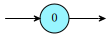

In [7]:
print(b.transitions)
# From d3 to vcsn
res = ''
for t in b.transitions:
    src = t['source'] if 'source' in t.keys() else '$'
    dst = t['target'] if 'target' in t.keys() else '$'
    res += "{} -> {} {}\n".format(src, dst, t['label'])
vcsn.automaton(res, 'daut')

In [8]:
# We can access to many thing on D3 model, here last State ID
b.lastStateId

0

In [9]:
# We can access to transitions on D3 model
b.transitions

[{'label': '', 'source': '0'}, {'label': '', 'target': '0'}]

In [10]:
# We can access to states on D3 model
b.states

[{'id': 0}]

In [11]:
# Here if we add an other nodes, then the force layout isn't run at the same time
# Have to check for Backbone.mode.changet and Widget.hold._sync
# and may add a posx, posy for every nodes
b.states = [{'id': 0}, {'id': 1}, {'id': 2}, {'id': 3}]

In [12]:
# Same problem as nodes
b.transitions

[{'label': '', 'source': '0'}, {'label': '', 'target': '0'}]

In [13]:
a = Automaton(states = [{'id': 0, 'initial': False, 'final': False, 'hidden': False}],
              transitions = [{'source': 0, 'target': 0, 'label': 'a', 'short': False}])
display(a)